In [1]:
#@title Installs
!pip install -q uv
!uv pip install -q --system "jax[cuda12]"
!uv pip install -q --system git+https://github.com/jax-md/jax-md.git
!uv pip install -q --system git+https://www.github.com/deepmind/haiku
!uv pip install -q --system git+https://www.github.com/deepmind/optax
!uv pip install -q --system pymatgen
!uv pip install -q --system mdtraj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 87.2 MB/s eta 0:00:00


In [2]:
#@title Imports
import pickle
import os
import numpy as onp
import copy
from jax import config
config.update('jax_enable_x64', True)

from typing import Callable, Tuple, TextIO, Dict, Any, Optional
import jax.numpy as jnp
import numpy as onp
import optax
from jax import jit, checkpoint
from jax import grad
from jax import vmap
from jax import random
from jax import lax
from jax import checkpoint, value_and_grad
from jax import jacfwd, jacrev, linearize
from jax import hessian
from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import energy, elasticity
from jax_md import partition
from jax_md import quantity, util, smap, units
from jax_md.util import f32, f64
from jax.scipy.optimize import minimize as jax_min
from scipy.optimize import minimize as scipy_min

import time
from typing import Callable, Tuple, TextIO, Dict, Any, Optional
from functools import wraps, partial
import pandas as pd
import mdtraj as md
# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
# Matplotlib plot settings
# plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 14})

from pymatgen.io.vasp.outputs import Xdatcar
units = units.metal_unit_system()

In [3]:
#@title Helper functions
def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_facecolor('white')
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def draw_training(params,i):
  # display.clear_output(wait=True)
  # display.display(plt.gcf())
  fig = plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.semilogy(train_energy_error)
  plt.semilogy(test_energy_error)
  plt.xlim([0, train_epochs])
  format_plot(r'Epoch', '$L$')
  plt.subplot(1, 2, 2)
  predicted = vectorized_energy_fn(params, example_positions)
  plt.plot(example_energies, predicted, 'o')
  plt.plot(jnp.linspace(-400, -300, 10), jnp.linspace(-400, -300, 10), '--')
  format_plot('$E_{label}$ $(eV)$', '$E_{predicted}$ $(eV)$')
  # finalize_plot((2, 1))
  plt.savefig(f"loss_prediction_{i}.png",dpi=300)
  plt.close()

def lattice(R_unit_cell, copies, lattice_vectors):
  """Repeats a unit cell along lattice vectors. """
  lattice_vectors = onp.array(lattice_vectors, f64)

  N, d = R_unit_cell.shape
  if isinstance(copies, int):
    copies = (copies,) * d

  if lattice_vectors.ndim == 0 or lattice_vectors.ndim == 1:
    cartesian = True
    L = onp.eye(d) * lattice_vectors[onp.newaxis, ...]
  elif lattice_vectors.ndim == 2:
    assert lattice_vectors.shape[0] == lattice_vectors.shape[1]
    cartesian = False
    L = onp.eye(d) / onp.array(copies)[onp.newaxis, ...]
    R_unit_cell /= onp.array(copies)[onp.newaxis, ...]
  else:
    raise ValueError()

  Rs = []
  for indices in onp.ndindex(copies):
    dR = 0.
    for idx, i in enumerate(indices):
      dR += i * L[idx]
    R = R_unit_cell + dR[onp.newaxis, :]
    Rs += [R]

  return onp.concatenate(Rs)

def pos_lattice(cord_frac, latvec, N_multiply):
  """
  Constructs supercell
  Args:
    cord_frac: Fractional co-ordinates (primitive/unit cell)
    latvec: Lattice vector (primitive/unit cell)
    N_replica: Number of replicas in 3 directions
  Returns:
    supercell co-ordinates and lattice vector
  """
  rows = cord_frac.split('\n')
  rows = jnp.array([list(map(float,r.split(' ')[:3])) for r in rows])
  R_supercell = lattice(rows, N_multiply, latvec)
  latvec_supercell = latvec * N_multiply
  R_supercell = jnp.array(R_supercell, f64)
  return R_supercell, latvec_supercell

# Data Loading.
def MD_trajectory_reader(f, no_skip=20):
  filename = os.path.join('/content/Supplementary/', f)
  fo = open(filename, 'r')
  samples = fo.read().split('iter= ')[1:]
  steps = []
  lattice_vectors = []
  positions = []
  forces = []
  temperatures = []
  energies = []
  for sample in samples[::no_skip]:
    entries = sample.split('\n')
    steps.append(int(entries[0]))
    lattice_vectors.append(onp.array([list(map(float, lv.split())) for lv in entries[1:4]]))
    assert entries[4]=='64'
    temp = onp.array([list(map(float, lv.split()[1:])) for lv in entries[5:69]])
    positions.append(temp[:,:3])
    forces.append(temp[:,3:])
    remaining_lines = entries[69:]
    temperatures.append(float([entry for entry in entries[69:] if 'Temp' in entry ][0].split('=')[1].split()[0]))
    energies.append(float([entry for entry in entries[69:] if 'el-ion E' in entry ][0].split('=')[1].split()[0]))
  assert (len(set(steps))-(steps[-1]-steps[0]+1)/no_skip) < 1
  return jnp.array(positions), jnp.array(energies), jnp.array(forces), jnp.array(lattice_vectors)

def build_dataset():
  no_skip = 15

  data300_cubic, energies300_cubic, forces300_cubic, latvec300_cubic = MD_trajectory_reader(
      'MD_DATA.cubic_300K', no_skip=no_skip)
  data600_cubic, energies600_cubic, forces600_cubic, latvec600_cubic = MD_trajectory_reader(
      'MD_DATA.cubic_600K', no_skip=no_skip)
  data900_cubic, energies900_cubic, forces900_cubic, latvec900_cubic = MD_trajectory_reader(
      'MD_DATA.cubic_900K', no_skip=no_skip)

  data_liq, energies_liq, forces_liq, latvec_liq = MD_trajectory_reader(
      'MD_DATA.liq_1', no_skip=no_skip)

  all_data = jnp.vstack((data300_cubic, data600_cubic, data900_cubic,
                         data_liq))

  all_energies = jnp.hstack((energies300_cubic, energies600_cubic, energies900_cubic,
                             energies_liq))

  all_forces = jnp.vstack((forces300_cubic, forces600_cubic, forces900_cubic,
                           forces_liq))

  all_latvec = jnp.vstack((latvec300_cubic, latvec600_cubic, latvec900_cubic,
                           latvec_liq))

  noTotal = all_data.shape[0]

  onp.random.seed(0)
  II = onp.random.permutation(range(noTotal))

  # Shuffle the data
  all_data = all_data[II]
  all_energies = all_energies[II]
  all_forces = all_forces[II]
  all_latvec = all_latvec[II]

  noTr = int(noTotal * 0.60)
  noVa = int(noTotal * 0.20)
  noTe = noTotal - (noTr + noVa)
  train_data = all_data[:noTr]
  val_data = all_data[noTr:noTr + noVa]
  test_data = all_data[noTr + noVa:]

  train_energies = all_energies[:noTr]
  val_energies = all_energies[noTr:noTr + noVa]
  test_energies = all_energies[noTr + noVa:]

  train_forces = all_forces[:noTr]
  val_forces  = all_forces[noTr:noTr + noVa]
  test_forces = all_forces[noTr + noVa:]

  train_latvec = all_latvec[:noTr]
  val_latvec  = all_latvec[noTr:noTr + noVa]
  test_latvec = all_latvec[noTr + noVa:]

  data_set = ((train_data, train_energies, train_forces, train_latvec),
              (val_data, val_energies, val_forces, val_latvec),
              (test_data, test_energies, test_forces, test_latvec))

  print(f"Train data = {len(train_data)}, Validation data = {len(val_data)}, Test data = {len(test_data)}")
  return data_set

In [4]:
#@title Load data and model weights
!wget -q https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/Si_DFT/Si_VASP_DFT_FC/XDATCAR
!wget -q https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/Si_DFT/Si_VASP_DFT_FC/XDATCAR_1000K
!wget -q https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/Si_DFT/Si_VASP_DFT_FC/XDATCAR_3000K
!wget -q https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/Si_DFT/Si_VASP_DFT_FC/XDATCAR_216
!wget -q https://raw.githubusercontent.com/google/jax-md/main/examples/models/si_gnn.pickle
!wget -q https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/GNN_model_weights/si_gnn_fine_tuned_final.pickle
!wget -q https://raw.githubusercontent.com/abhijeetgangan/silicon_data/main/GNN_model_weights/si_gnn_rdf_fine_tuned_final.pickle

In [5]:
!wget https://pubs.aip.org/jcp/article-supplement/988620/zip/024104_1_supplements
!unzip -q 024104_1_supplements  # wrapper for `Supplementary.zip`.
!unzip -q Supplementary.zip

# You can download it manually from the website if this gives 403 error

--2025-03-11 12:05:48--  https://pubs.aip.org/jcp/article-supplement/988620/zip/024104_1_supplements
Resolving pubs.aip.org (pubs.aip.org)... 104.18.12.179, 104.18.13.179
Connecting to pubs.aip.org (pubs.aip.org)|104.18.12.179|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-03-11 12:05:48 ERROR 403: Forbidden.



## Prepare dataset

In [6]:
xdatcar = Xdatcar('/content/XDATCAR')
xdatcar_1000K = Xdatcar('/content/XDATCAR_1000K')
xdatcar_3000K  = Xdatcar('/content/XDATCAR_3000K')
xdatcar_216 = Xdatcar('/content/XDATCAR_216')

structures = xdatcar.structures
structures_1000K = xdatcar_1000K.structures
structures_3000K = xdatcar_3000K.structures
structures_216 = xdatcar_216.structures

In [7]:
# You can download the data manually if it gives 403 error
train, val, test = build_dataset()
positions, energies, forces, latvec = train
val_positions, val_energies, val_forces, val_latvec = val
test_positions, test_energies, test_forces, test_latvec = test

Train data = 2578, Validation data = 859, Test data = 860


In [8]:
print(f'Train data = {len(energies)}, Val data {len(val_energies)}, Test data {len(test_energies)}')

Train data = 2578, Val data 859, Test data 860


### RDF from DFT

In [9]:
# RDF settings
dr = 5/400
num_radii = 550
r = jnp.linspace(0.001, 5.5001, num_radii, dtype=f64)

latvec_DFT = jnp.array([
    [structures[0].lattice.a, 0.00000, 0.00000],
    [0.00000, structures[0].lattice.b, 0.00000],
    [0.00000, 0.00000, structures[0].lattice.c]])

latvec_DFT_1000K = jnp.array([
    [structures_1000K[0].lattice.a, 0.00000, 0.00000],
    [0.00000, structures_1000K[0].lattice.b, 0.00000],
    [0.00000, 0.00000, structures_1000K[0].lattice.c]])

latvec_DFT_3000K = jnp.array([
    [structures_3000K[0].lattice.a, 0.00000, 0.00000],
    [0.00000, structures_3000K[0].lattice.b, 0.00000],
    [0.00000, 0.00000, structures_3000K[0].lattice.c]])

latvec_DFT_216 = jnp.array([
    [structures_216[0].lattice.a, 0.00000, 0.00000],
    [0.00000, structures_216[0].lattice.b, 0.00000],
    [0.00000, 0.00000, structures_216[0].lattice.c]])

pos_DFT = jnp.array(structures[0].cart_coords, dtype=jnp.float64)
pos_DFT_1000K = jnp.array(structures_1000K[0].cart_coords, dtype=jnp.float64)
pos_DFT_3000K  = jnp.array(structures_3000K[0].cart_coords, dtype=jnp.float64)
pos_DFT_216 = jnp.array(structures_216[0].cart_coords, dtype=jnp.float64)

displacement_DFT, shift_DFT = space.periodic(latvec_DFT[0,0])
displacement_DFT_1000K, shift_DFT_1000K = space.periodic(latvec_DFT_1000K[0,0])
displacement_DFT_3000K, shift_DFT_3000K, = space.periodic(latvec_DFT_3000K[0,0])
displacement_DFT_216, shift_DFT = space.periodic(latvec_DFT_216[0,0])

gr_fn_DFT = jit(quantity.pair_correlation(displacement_DFT, radii=r, sigma=4 * dr, compute_average=True))
gr_fn_DFT_1000K = jit(quantity.pair_correlation(displacement_DFT_1000K, radii=r, sigma=4 * dr, compute_average=True))
gr_fn_DFT_3000K = jit(quantity.pair_correlation(displacement_DFT_3000K, radii=r, sigma=4 * dr, compute_average=True))
gr_fn_DFT_216 = jit(quantity.pair_correlation(displacement_DFT_216, radii=r, sigma=4 * dr, compute_average=True))

MD_STEPS = 5000
gr_DFT = onp.zeros((MD_STEPS, num_radii))
gr_DFT_1000K = onp.zeros((MD_STEPS, num_radii))
gr_DFT_3000K = onp.zeros((MD_STEPS, num_radii))
gr_DFT_216 = onp.zeros((MD_STEPS, num_radii))

ref_pos_DFT = jnp.array([i.cart_coords for i in structures[5000:]], dtype=jnp.float64)
ref_pos_1000K_DFT = jnp.array([i.cart_coords for i in structures_1000K[5000:]], dtype=jnp.float64)
ref_pos_3000K_DFT= jnp.array([i.cart_coords for i in structures_3000K[5000:]], dtype=jnp.float64)
ref_pos_216_DFT = jnp.array([i.cart_coords for i in structures_216[5000:]], dtype=jnp.float64)

for i in range(MD_STEPS):
  gr_DFT[i, :] = gr_fn_DFT(structures[10000 - MD_STEPS + i].cart_coords)
  gr_DFT_1000K[i, :] = gr_fn_DFT_1000K(structures_1000K[10000 - MD_STEPS + i].cart_coords)
  gr_DFT_3000K[i, :] = gr_fn_DFT_3000K(structures_3000K[10000 - MD_STEPS + i].cart_coords)
  gr_DFT_216[i, :] = gr_fn_DFT_216(structures_216[10000 - MD_STEPS + i].cart_coords)

In [10]:
fig = plt.figure(figsize=(8, 6))
plt.plot(r,jnp.mean(gr_DFT_1000K, axis=0), linewidth=3, label='N=64, T=1000K')
plt.plot(r,jnp.mean(gr_DFT, axis=0), linewidth=3, label='N=64, T=2000K')
plt.plot(r,jnp.mean(gr_DFT_3000K, axis=0), linewidth=3, label='N=64, T=3000K')
plt.plot(r,jnp.mean(gr_DFT_216, axis=0), linewidth=3, label='N=216, T=2000K')
plt.ylabel(r"$g(r)$", fontsize=16)
plt.xlabel(r"$r\ (\AA)$", fontsize=16)
plt.xlim([r[0], r[-1]])
plt.legend()
plt.savefig("RDF_DFT.png",dpi=300)
plt.close()

In [11]:
DFT_pos = jnp.array(structures[10000 - MD_STEPS].cart_coords, dtype=jnp.float64)
DFT_pos_1000K = jnp.array(structures_1000K[10000 - MD_STEPS].cart_coords, dtype=jnp.float64)
DFT_pos_3000K = jnp.array(structures_3000K[10000 - MD_STEPS].cart_coords, dtype=jnp.float64)
DFT_pos_216 = jnp.array(structures_216[10000 - MD_STEPS].cart_coords, dtype=jnp.float64)

gr_converged = jnp.mean(gr_DFT, axis=0)
gr_converged_1000K = jnp.mean(gr_DFT_1000K, axis=0)
gr_converged_3000K = jnp.mean(gr_DFT_3000K, axis=0)
gr_converged_216 = jnp.mean(gr_DFT_216, axis=0)

box_size = jnp.array([10.862, 10.862, 10.862])  # The size of the simulation region.

## Define GNN model

In [12]:
box_size = jnp.array([10.862, 10.862, 10.862])  # The size of the simulation region.
displacement, shift = space.periodic(box_size[0])

neighbor_fn, init_fn, energy_fn = energy.graph_network_neighbor_list(displacement, box_size[0], r_cutoff=3.0, dr_threshold=0.0)

neighbor = neighbor_fn.allocate(positions[0], extra_capacity=6)
print('Allocating space for at most {} edges'.format(neighbor.idx.shape[1]))

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Allocating space for at most 784 edges


## MD simulation

In [13]:
def setup_md(R, latvec, Temp, target_gr):
  dt = 1e-3 # fs
  steps = 10000
  key = random.PRNGKey(0)
  key, split = random.split(key)
  write_every = 1
  dr = 5/400
  r = jnp.linspace(0.001, 5.501, num_radii, dtype=f64)
  T_init = Temp
  Mass = 28.0855 * units['mass']

  displacement, shift = space.periodic(latvec[0,0])
  neighbor_fn, init_fn, energy_fn = energy.graph_network_neighbor_list(displacement, latvec[0,0], r_cutoff=3.0, dr_threshold=0.0)
  neighbor = neighbor_fn.allocate(R, extra_capacity=6)

  gr_fn = jit(quantity.pair_correlation(displacement, radii=r, sigma=dr * 4))

  logger = {
        'gr': jnp.zeros((steps // write_every,) + r.shape),
        'pos': jnp.zeros((steps // write_every,) + R.shape)
        }

  def run(params):

    @jit
    def step_fn(i, state_nbrs_log):
      state, nbrs, log = state_nbrs_log
      t = i * dt * units['time']
      # Log information about the simulation.
      gr_measured = jnp.mean(gr_fn(state.position),axis=0)
      log['gr'] =  log['gr'].at[i].set(gr_measured)
      log['pos'] = log['pos'].at[i].set(state.position)
      # Take a simulation step.
      state = apply_fn(state, neighbor=nbrs, kT=T_init * units['temperature'])
      nbrs = nbrs.update(state.position, neighbor=nbrs)
      return state, nbrs, log


    energy_fn_gnn = jit(partial(energy_fn, params))
    init_fn, apply_fn = simulate.nve(energy_fn_gnn, shift, dt=dt * units['time'], kT=T_init * units['temperature'])
    state = init_fn(key, R, neighbor=neighbor, kT=T_init * units['temperature'], mass=Mass)
    state_run, nbrs_run, log_run = lax.fori_loop(0, steps, step_fn, (state, neighbor, logger))

    return jnp.sum(jnp.power(jnp.mean(log_run['gr'], axis=0) - target_gr, 2)) /  jnp.sum(jnp.power(target_gr, 2)), log_run
  return run


## Define loss function

In [14]:
@jit
def train_energy_fn(params, R):
  _neighbor = neighbor.update(R)
  return energy_fn(params, R, _neighbor)

vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

grad_fn = grad(train_energy_fn, argnums=1)
force_fn = lambda params, R, **kwargs: -grad_fn(params, R)
vectorized_force_fn = vmap(force_fn, (None, 0))

run_md = setup_md(DFT_pos, latvec_DFT, Temp=2000.0, target_gr=gr_converged)
run_md_1000K = setup_md(DFT_pos_1000K, latvec_DFT_1000K, Temp=1000.0, target_gr=gr_converged_1000K)
run_md_3000K = setup_md(DFT_pos_3000K, latvec_DFT_3000K, Temp=3000.0, target_gr=gr_converged_3000K)
run_md_216 = setup_md(DFT_pos_216, latvec_DFT_216, Temp=2000.0, target_gr=gr_converged_216)

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types

In [15]:
@jit
def energy_loss(params, R, energy_targets):
  return jnp.mean((vectorized_energy_fn(params, R) - energy_targets) ** 2)

@jit
def energy_loss_MAE(params, R, energy_targets):
  return jnp.mean(jnp.abs(vectorized_energy_fn(params, R) - energy_targets))

@jit
def force_loss(params, R, force_targets):
  dforces = vectorized_force_fn(params, R) - force_targets
  return jnp.mean(jnp.sum(dforces ** 2, axis=(1, 2)))

@jit
def force_loss_MAE(params, R, force_targets):
  dforces = jnp.abs(vectorized_force_fn(params, R) - force_targets)
  return jnp.mean(jnp.sum(dforces, axis=(1, 2)))

@jit
def loss(params, R, targets):
  return energy_loss(params, R, targets[0]) + force_loss(params, R, targets[1]) + 2000*run_md(params)[0]

## Load model weights

In [16]:
key = random.PRNGKey(0)

with open('/content/si_gnn.pickle', 'rb') as f:
  params_si_gnn = pickle.load(f)

with open('/content/si_gnn_fine_tuned_final.pickle', 'rb') as f:
  params_si_gnn_fine_tuned = pickle.load(f)

with open('/content/si_gnn_rdf_fine_tuned_final.pickle', 'rb') as f:
  params_si_gnn_rdf_fine_tuned = pickle.load(f)

In [17]:
def plot_comparison(model, params, test_positions, test_energies, test_forces):
  plt.subplot(1, 2, 1)
  predicted_energies = vectorized_energy_fn(params, test_positions)
  plt.plot(test_energies, predicted_energies, 'o')
  plt.xlabel(r'$\mathrm{E_{True}}\ (\mathrm{eV})$', fontsize=20)
  plt.ylabel(r'$\mathrm{E_{Predicted}}\ (\mathrm{eV})$', fontsize=20)
  plt.plot(jnp.linspace(min(test_energies), max(test_energies), 20), jnp.linspace(min(test_energies), max(test_energies), 20), '--')
  plt.xlim([min(test_energies), max(test_energies)])
  plt.ylim([min(test_energies), max(test_energies)])
  plt.subplot(1, 2, 2)
  predicted_forces = vectorized_force_fn(params, test_positions)
  plt.plot(test_forces.reshape((-1,)),predicted_forces.reshape((-1,)),'o')
  plt.plot(jnp.linspace(-8, 8, 20), jnp.linspace(-8, 8, 20), '--')
  plt.xlim([-6, 6])
  plt.ylim([-6, 6])
  plt.xlabel(r'$\mathrm{F_{True}}\ (\mathrm{eV/\AA})$', fontsize=20)
  plt.ylabel(r'$\mathrm{F_{Predicted}}\ (\mathrm{eV/\AA})$', fontsize=20)
  finalize_plot((2, 1))
  plt.savefig(f"comp_{model}.png",dpi=300)
  plt.close()

In [18]:
plot_comparison("si_gnn", params_si_gnn, test_positions, test_energies, test_forces)
plot_comparison("si_gnn_fine_tuned", params_si_gnn_fine_tuned, test_positions, test_energies, test_forces)
plot_comparison("si_gnn_rdf_fine_tuned", params_si_gnn_rdf_fine_tuned, test_positions, test_energies, test_forces)

In [19]:
model = "si_gnn"
params = params_si_gnn

rdf_loss, rdf_pred = run_md(params)
rdf_loss_1000K, rdf_pred_1000K = run_md_1000K(params)
rdf_loss_3000K, rdf_pred_3000K = run_md_3000K(params)
rdf_loss_216, rdf_pred_216 = run_md_216(params)

# Train error
E_MSE_error_train = energy_loss(params, positions, energies) * 1000 / 64
F_MSE_error_train = force_loss(params, positions, forces) * 1000 / 64 / 3

E_RMSE_error_train = jnp.sqrt(energy_loss(params, positions, energies) * 1000 / 64)
F_RMSE_error_train = jnp.sqrt(force_loss(params, positions, forces)* 1000 / 64 / 3)

E_MAE_error_train = energy_loss_MAE(params, positions, energies) * 1000 / 64
F_MAE_error_train = force_loss_MAE(params, positions, forces) * 1000 / 64 / 3

# Validation error
E_MSE_error_val = energy_loss(params, val_positions, val_energies) * 1000 / 64
F_MSE_error_val = force_loss(params, val_positions, val_forces) * 1000 / 64 / 3

E_RMSE_error_val = jnp.sqrt(energy_loss(params, val_positions, val_energies)  * 1000 / 64)
F_RMSE_error_val = jnp.sqrt(force_loss(params, val_positions, val_forces) * 1000 / 64 / 3)

E_MAE_error_val = energy_loss_MAE(params, val_positions, val_energies) * 1000 / 64
F_MAE_error_val = force_loss_MAE(params, val_positions, val_forces) * 1000 / 64 / 3

# Test error
E_MSE_error_test = energy_loss(params, test_positions, test_energies) * 1000 / 64
F_MSE_error_test = force_loss(params, test_positions, test_forces) * 1000 / 64 / 3

E_RMSE_error_test = jnp.sqrt(energy_loss(params, test_positions, test_energies)  * 1000 / 64)
F_RMSE_error_test = jnp.sqrt(force_loss(params, test_positions, test_forces) * 1000 / 64 / 3)

E_MAE_error_test = energy_loss_MAE(params, test_positions, test_energies) * 1000 / 64
F_MAE_error_test = force_loss_MAE(params, test_positions, test_forces) * 1000 / 64 / 3

print(f"Model = {model}, MSE Train Energy error : {E_MSE_error_train:.3E}, Train Force error : {F_MSE_error_train:.3E}")
print(f"Model = {model}, MSE Val Energy error : {E_MSE_error_val:.3E}, Val Force error : {F_MSE_error_val:.3E}")
print(f"Model = {model}, MSE Test Energy error : {E_MSE_error_test:.3E}, Val Force error : {F_MSE_error_test:.3E}")

print(f"Model = {model}, RMSE Train Energy error : {E_RMSE_error_train:.3E}, Train Force error : {F_RMSE_error_train:.3E}")
print(f"Model = {model}, RMSE Val Energy error : {E_RMSE_error_val:.3E}, Val Force error : {F_RMSE_error_val:.3E}")
print(f"Model = {model}, RMSE Test Energy error : {E_RMSE_error_test:.3E}, Val Force error : {F_RMSE_error_test:.3E}")

print(f"Model = {model}, MAE Train Energy error : {E_MAE_error_train:.3E}, Train Force error : {F_MAE_error_train:.3E}")
print(f"Model = {model}, MAE Val Energy error : {E_MAE_error_val:.3E}, Val Force error : {F_MAE_error_val:.3E}")
print(f"Model = {model}, MAE Test Energy error : {E_MAE_error_test:.3E}, Val Force error : {F_MAE_error_test:.3E}")

print(f"Model = {model}, RDF error : {rdf_loss:.3E}")
print(f"Model = {model}, RDF error 1000K: {rdf_loss_1000K:.3E}")
print(f"Model = {model}, RDF error 3000K: {rdf_loss_3000K:.3E}")
print(f"Model = {model}, RDF error 216: {rdf_loss_216:.3E}")

gr = rdf_pred['gr']
gr_1000K = rdf_pred_1000K['gr']
gr_3000K = rdf_pred_3000K['gr']
gr_216 = rdf_pred_216['gr']

pos = rdf_pred['pos']
pos_1000K = rdf_pred_1000K['pos']
pos_3000K = rdf_pred_3000K['pos']
pos_216 = rdf_pred_216['pos']

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types

Model = si_gnn, MSE Train Energy error : 1.503E+01, Train Force error : 5.143E+01
Model = si_gnn, MSE Val Energy error : 1.633E+01, Val Force error : 5.463E+01
Model = si_gnn, MSE Test Energy error : 1.634E+01, Val Force error : 5.266E+01
Model = si_gnn, RMSE Train Energy error : 3.877E+00, Train Force error : 7.172E+00
Model = si_gnn, RMSE Val Energy error : 4.041E+00, Val Force error : 7.391E+00
Model = si_gnn, RMSE Test Energy error : 4.042E+00, Val Force error : 7.257E+00
Model = si_gnn, MAE Train Energy error : 9.517E+00, Train Force error : 1.303E+02
Model = si_gnn, MAE Val Energy error : 1.026E+01, Val Force error : 1.389E+02
Model = si_gnn, MAE Test Energy error : 1.011E+01, Val Force error : 1.328E+02
Model = si_gnn, RDF error : 2.874E+03
Model = si_gnn, RDF error 1000K: 1.344E-02
Model = si_gnn, RDF error 3000K: 1.372E+03
Model = si_gnn, RDF error 216: 2.212E+03


In [20]:
model_ft = "si_gnn_fine_tuned"
params_ft = params_si_gnn_fine_tuned

rdf_loss_ft, rdf_pred_ft = run_md(params_ft)
rdf_loss_1000K_ft, rdf_pred_1000K_ft = run_md_1000K(params_ft)
rdf_loss_3000K_ft, rdf_pred_3000K_ft = run_md_3000K(params_ft)
rdf_loss_216_ft, rdf_pred_216_ft = run_md_216(params_ft)

# Train error
E_MSE_error_train = energy_loss(params_ft, positions, energies) * 1000 / 64
F_MSE_error_train = force_loss(params_ft, positions, forces) * 1000 / 64 / 3

E_RMSE_error_train = jnp.sqrt(energy_loss(params_ft, positions, energies) * 1000 / 64)
F_RMSE_error_train = jnp.sqrt(force_loss(params_ft, positions, forces) * 1000 / 64 / 3)

E_MAE_error_train = energy_loss_MAE(params_ft, positions, energies) * 1000 / 64
F_MAE_error_train = force_loss_MAE(params_ft, positions, forces) * 1000 / 64 / 3

# Validation error
E_MSE_error_val = energy_loss(params_ft, val_positions, val_energies) * 1000 / 64
F_MSE_error_val = force_loss(params_ft, val_positions, val_forces) * 1000 / 64 / 3

E_RMSE_error_val = jnp.sqrt(energy_loss(params_ft, val_positions, val_energies) * 1000 / 64)
F_RMSE_error_val = jnp.sqrt(force_loss(params_ft, val_positions, val_forces)* 1000 / 64 / 3)

E_MAE_error_val = energy_loss_MAE(params_ft, val_positions, val_energies) * 1000 / 64
F_MAE_error_val = force_loss_MAE(params_ft, val_positions, val_forces) * 1000 / 64 / 3

# Test error
E_MSE_error_test = energy_loss(params_ft, test_positions, test_energies) * 1000 / 64
F_MSE_error_test = force_loss(params_ft, test_positions, test_forces) * 1000 / 64 / 3

E_RMSE_error_test = jnp.sqrt(energy_loss(params_ft, test_positions, test_energies) * 1000 / 64)
F_RMSE_error_test = jnp.sqrt(force_loss(params_ft, test_positions, test_forces)* 1000 / 64 / 3)

E_MAE_error_test = energy_loss_MAE(params_ft, test_positions, test_energies) * 1000 / 64
F_MAE_error_test = force_loss_MAE(params_ft, test_positions, test_forces) * 1000 / 64 / 3

print(f"Model = {model_ft}, MSE Train Energy error : {E_MSE_error_train:.3E}, Train Force error : {F_MSE_error_train:.3E}")
print(f"Model = {model_ft}, MSE Val Energy error : {E_MSE_error_val:.3E}, Val Force error : {F_MSE_error_val:.3E}")
print(f"Model = {model_ft}, MSE Test Energy error : {E_MSE_error_test:.3E}, Val Force error : {F_MSE_error_test:.3E}")

print(f"Model = {model_ft}, RMSE Train Energy error : {E_RMSE_error_train:.3E}, Train Force error : {F_RMSE_error_train:.3E}")
print(f"Model = {model_ft}, RMSE Val Energy error : {E_RMSE_error_val:.3E}, Val Force error : {F_RMSE_error_val:.3E}")
print(f"Model = {model_ft}, RMSE Test Energy error : {E_RMSE_error_test:.3E}, Val Force error : {F_RMSE_error_test:.3E}")

print(f"Model = {model_ft}, MAE Train Energy error : {E_MAE_error_train:.3E}, Train Force error : {F_MAE_error_train:.3E}")
print(f"Model = {model_ft}, MAE Val Energy error : {E_MAE_error_val:.3E}, Val Force error : {F_MAE_error_val:.3E}")
print(f"Model = {model_ft}, MAE Test Energy error : {E_MAE_error_test:.3E}, Val Force error : {F_MAE_error_test:.3E}")

print(f"Model = {model_ft}, RDF error 1000K: {rdf_loss_1000K_ft:.3E}")
print(f"Model = {model_ft}, RDF error 3000K: {rdf_loss_3000K_ft:.3E}")
print(f"Model = {model_ft}, RDF error 216: {rdf_loss_216_ft:.3E}")

gr_ft = rdf_pred_ft['gr']
gr_1000K_ft = rdf_pred_1000K_ft['gr']
gr_3000K_ft = rdf_pred_3000K_ft['gr']
gr_216_ft = rdf_pred_216_ft['gr']

pos_ft = rdf_pred_ft['pos']
pos_1000K_ft = rdf_pred_1000K_ft['pos']
pos_3000K_ft = rdf_pred_3000K_ft['pos']
pos_216_ft = rdf_pred_216_ft['pos']

Model = si_gnn_fine_tuned, MSE Train Energy error : 5.063E-01, Train Force error : 8.725E+00
Model = si_gnn_fine_tuned, MSE Val Energy error : 1.070E+00, Val Force error : 1.484E+01
Model = si_gnn_fine_tuned, MSE Test Energy error : 1.093E+00, Val Force error : 1.403E+01
Model = si_gnn_fine_tuned, RMSE Train Energy error : 7.115E-01, Train Force error : 2.954E+00
Model = si_gnn_fine_tuned, RMSE Val Energy error : 1.034E+00, Val Force error : 3.852E+00
Model = si_gnn_fine_tuned, RMSE Test Energy error : 1.046E+00, Val Force error : 3.745E+00
Model = si_gnn_fine_tuned, MAE Train Energy error : 1.859E+00, Train Force error : 5.759E+01
Model = si_gnn_fine_tuned, MAE Val Energy error : 2.662E+00, Val Force error : 7.413E+01
Model = si_gnn_fine_tuned, MAE Test Energy error : 2.635E+00, Val Force error : 6.924E+01
Model = si_gnn_fine_tuned, RDF error 1000K: 1.685E-02
Model = si_gnn_fine_tuned, RDF error 3000K: 2.273E+02
Model = si_gnn_fine_tuned, RDF error 216: 4.782E+02


In [21]:
model_rdf_ft = "si_gnn_rdf_fine_tuned"
params_rdf_ft = params_si_gnn_rdf_fine_tuned

rdf_loss_rdf_ft, rdf_pred_rdf_ft = run_md(params_rdf_ft)
rdf_loss_1000K_rdf_ft, rdf_pred_1000K_rdf_ft = run_md_1000K(params_rdf_ft)
rdf_loss_3000K_rdf_ft, rdf_pred_3000K_rdf_ft = run_md_3000K(params_rdf_ft)
rdf_loss_216_rdf_ft, rdf_pred_216_rdf_ft = run_md_216(params_rdf_ft)

# Train error
E_MSE_error_train = energy_loss(params_rdf_ft, positions, energies) * 1000 / 64
F_MSE_error_train = force_loss(params_rdf_ft, positions, forces) * 1000 / 64 / 3

E_RMSE_error_train = jnp.sqrt(energy_loss(params_rdf_ft, positions, energies) * 1000 / 64)
F_RMSE_error_train = jnp.sqrt(force_loss(params_rdf_ft, positions, forces) * 1000 / 64 / 3)

E_MAE_error_train = energy_loss_MAE(params_rdf_ft, positions, energies) * 1000 / 64
F_MAE_error_train = force_loss_MAE(params_rdf_ft, positions, forces) * 1000 / 64 / 3

# Validation error
E_MSE_error_val = energy_loss(params_rdf_ft, val_positions, val_energies) * 1000 / 64
F_MSE_error_val = force_loss(params_rdf_ft, val_positions, val_forces) * 1000 / 64 / 3

E_RMSE_error_val = jnp.sqrt(energy_loss(params_rdf_ft, val_positions, val_energies) * 1000 / 64)
F_RMSE_error_val = jnp.sqrt(force_loss(params_rdf_ft, val_positions, val_forces) * 1000 / 64 / 3)

E_MAE_error_val = energy_loss_MAE(params_rdf_ft, val_positions, val_energies) * 1000 / 64
F_MAE_error_val = force_loss_MAE(params_rdf_ft, val_positions, val_forces) * 1000 / 64 / 3

# Test error
E_MSE_error_test = energy_loss(params_rdf_ft, test_positions, test_energies) * 1000 / 64
F_MSE_error_test = force_loss(params_rdf_ft, test_positions, test_forces) * 1000 / 64 / 3

E_RMSE_error_test = jnp.sqrt(energy_loss(params_rdf_ft, test_positions, test_energies) * 1000 / 64)
F_RMSE_error_test = jnp.sqrt(force_loss(params_rdf_ft, test_positions, test_forces) * 1000 / 64 / 3)

E_MAE_error_test = energy_loss_MAE(params_rdf_ft, test_positions, test_energies) * 1000 / 64
F_MAE_error_test = force_loss_MAE(params_rdf_ft, test_positions, test_forces) * 1000 / 64 / 3

print(f"Model = {model_rdf_ft}, MSE Train Energy error : {E_MSE_error_train:.3E}, Train Force error : {F_MSE_error_train:.3E}")
print(f"Model = {model_rdf_ft}, MSE Val Energy error : {E_MSE_error_val:.3E}, Val Force error : {F_MSE_error_val:.3E}")
print(f"Model = {model_rdf_ft}, MSE Test Energy error : {E_MSE_error_test:.3E}, Val Force error : {F_MSE_error_test:.3E}")

print(f"Model = {model_rdf_ft}, RMSE Train Energy error : {E_RMSE_error_train:.3E}, Train Force error : {F_RMSE_error_train:.3E}")
print(f"Model = {model_rdf_ft}, RMSE Val Energy error : {E_RMSE_error_val:.3E}, Val Force error : {F_RMSE_error_val:.3E}")
print(f"Model = {model_rdf_ft}, RMSE Test Energy error : {E_RMSE_error_test:.3E}, Val Force error : {F_RMSE_error_test:.3E}")

print(f"Model = {model_rdf_ft}, MAE Train Energy error : {E_MAE_error_train:.3E}, Train Force error : {F_MAE_error_train:.3E}")
print(f"Model = {model_rdf_ft}, MAE Val Energy error : {E_MAE_error_val:.3E}, Val Force error : {F_MAE_error_val:.3E}")
print(f"Model = {model_rdf_ft}, MAE Test Energy error : {E_MAE_error_test:.3E}, Val Force error : {F_MAE_error_test:.3E}")

print(f"Model = {model_rdf_ft}, RDF error 1000K: {rdf_loss_1000K_rdf_ft:.3E}")
print(f"Model = {model_rdf_ft}, RDF error 3000K: {rdf_loss_3000K_rdf_ft:.3E}")
print(f"Model = {model_rdf_ft}, RDF error 216: {rdf_loss_216_rdf_ft:.3E}")

gr_rdf_ft = rdf_pred_rdf_ft['gr']
gr_1000K_rdf_ft = rdf_pred_1000K_rdf_ft['gr']
gr_3000K_rdf_ft = rdf_pred_3000K_rdf_ft['gr']
gr_216_rdf_ft = rdf_pred_216_rdf_ft['gr']

pos_rdf_ft = rdf_pred_rdf_ft['pos']
pos_1000K_rdf_ft = rdf_pred_1000K_rdf_ft['pos']
pos_3000K_rdf_ft = rdf_pred_3000K_rdf_ft['pos']
pos_216_rdf_ft = rdf_pred_216_rdf_ft['pos']

Model = si_gnn_rdf_fine_tuned, MSE Train Energy error : 5.936E-01, Train Force error : 9.173E+00
Model = si_gnn_rdf_fine_tuned, MSE Val Energy error : 1.145E+00, Val Force error : 1.470E+01
Model = si_gnn_rdf_fine_tuned, MSE Test Energy error : 1.162E+00, Val Force error : 1.361E+01
Model = si_gnn_rdf_fine_tuned, RMSE Train Energy error : 7.705E-01, Train Force error : 3.029E+00
Model = si_gnn_rdf_fine_tuned, RMSE Val Energy error : 1.070E+00, Val Force error : 3.834E+00
Model = si_gnn_rdf_fine_tuned, RMSE Test Energy error : 1.078E+00, Val Force error : 3.689E+00
Model = si_gnn_rdf_fine_tuned, MAE Train Energy error : 2.096E+00, Train Force error : 5.863E+01
Model = si_gnn_rdf_fine_tuned, MAE Val Energy error : 2.821E+00, Val Force error : 7.405E+01
Model = si_gnn_rdf_fine_tuned, MAE Test Energy error : 2.819E+00, Val Force error : 6.888E+01
Model = si_gnn_rdf_fine_tuned, RDF error 1000K: 1.521E-02
Model = si_gnn_rdf_fine_tuned, RDF error 3000K: 1.051E+02
Model = si_gnn_rdf_fine_tuned

In [22]:
# Save for plotting
onp.save("radii_jaxmd", r)

onp.save("gr_converged_jaxmd", gr_converged)
onp.save("gr_jaxmd", jnp.mean(gr, axis=0))
onp.save("gr_ft_jaxmd", jnp.mean(gr_ft, axis=0))
onp.save("gr_rdf_ft_jaxmd", jnp.mean(gr_rdf_ft, axis=0))

onp.save("gr_converged_1000K_jaxmd", gr_converged_1000K)
onp.save("gr_1000K_jaxmd", jnp.mean(gr_1000K, axis=0))
onp.save("gr_1000K_ft_jaxmd", jnp.mean(gr_1000K_ft, axis=0))
onp.save("gr_1000K_rdf_ft_jaxmd", jnp.mean(gr_1000K_rdf_ft, axis=0))

onp.save("gr_converged_3000K_jaxmd", gr_converged_3000K)
onp.save("gr_3000K_jaxmd", jnp.mean(gr_3000K, axis=0))
onp.save("gr_3000K_ft_jaxmd", jnp.mean(gr_3000K_ft, axis=0))
onp.save("gr_3000K_rdf_ft_jaxmd", jnp.mean(gr_3000K_rdf_ft, axis=0))

onp.save("gr_converged_216_jaxmd", gr_converged_216)
onp.save("gr_216_jaxmd", jnp.mean(gr_216, axis=0))
onp.save("gr_216_ft_jaxmd", jnp.mean(gr_216_ft, axis=0))
onp.save("gr_216_rdf_ft_jaxmd", jnp.mean(gr_216_rdf_ft, axis=0))

In [23]:
def compute_rdf_mdt(positions, box_size, r_range=(0.001, 5.501), bin_width=0.025):
    """Compute radial distribution function using MDTraj.

    Args:
        positions: Array of shape (n_frames, n_atoms, 3) containing atomic positions
        box_size: Size of periodic box
        r_range: Tuple of (min_r, max_r) for RDF calculation
        bin_width: Width of RDF bins

    Returns:
        r: Array of radii values
        g_r: Array of RDF values
    """

    # Convert positions to nanometers for MDTraj
    positions_nm = positions * 0.1  # Convert Angstrom to nm
    box_nm = box_size * 0.1

    # Create MDTraj trajectory object
    # cubic box
    unitcell_lengths = onp.tile([box_nm[0]], (len(positions), 3))
    unitcell_angles = onp.tile([90, 90, 90], (len(positions), 1))

    # Create topology with all atoms as the same type
    top = md.Topology()
    chain = top.add_chain()
    residue = top.add_residue('RES', chain)
    for i in range(positions.shape[1]):
        top.add_atom('Si', md.element.silicon, residue)

    # Create trajectory
    traj = md.Trajectory(positions_nm, top,
                        unitcell_lengths=unitcell_lengths,
                        unitcell_angles=unitcell_angles)

    # Calculate all pairs
    n_atoms = positions.shape[1]
    pairs = []
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            pairs.append([i,j])
    pairs = onp.array(pairs)

    # Compute RDF
    r, g_r = md.compute_rdf(traj, pairs,
                           r_range=(r_range[0]*0.1, r_range[1]*0.1),  # Convert to nm
                           bin_width=bin_width*0.1,  # Convert to nm
                           periodic=True)

    # Convert r back to Angstroms
    r = r * 10

    return r, g_r

box_size_216 = jnp.array([latvec_DFT_216[0,0], latvec_DFT_216[1,1], latvec_DFT_216[2,2]], dtype=jnp.float64)
box_size = jnp.array([latvec_DFT[0,0], latvec_DFT[1,1], latvec_DFT[2,2]], dtype=jnp.float64)
box_size_1000K = jnp.array([latvec_DFT_1000K[0,0], latvec_DFT_1000K[1,1], latvec_DFT_1000K[2,2]], dtype=jnp.float64)
box_size_3000K = jnp.array([latvec_DFT_3000K[0,0], latvec_DFT_3000K[1,1], latvec_DFT_3000K[2,2]], dtype=jnp.float64)

r_mdt_DFT, gr_mdt_DFT = compute_rdf_mdt(ref_pos_DFT, box_size)
r_mdt, gr_mdt = compute_rdf_mdt(pos, box_size)
r_mdt_ft, gr_mdt_ft = compute_rdf_mdt(pos_ft, box_size)
r_mdt_rdf_ft, gr_mdt_rdf_ft = compute_rdf_mdt(pos_rdf_ft, box_size)

r_mdt_DFT_1000K, gr_mdt_DFT_1000K = compute_rdf_mdt(ref_pos_1000K_DFT, box_size_1000K)
r_mdt_1000K, gr_mdt_1000K = compute_rdf_mdt(pos_1000K, box_size_1000K)
r_mdt_ft_1000K, gr_mdt_ft_1000K = compute_rdf_mdt(pos_1000K_ft, box_size_1000K)
r_mdt_rdf_ft_1000K, gr_mdt_rdf_ft_1000K = compute_rdf_mdt(pos_1000K_rdf_ft, box_size_1000K)

r_mdt_DFT_3000K, gr_mdt_DFT_3000K = compute_rdf_mdt(ref_pos_3000K_DFT, box_size_3000K)
r_mdt_3000K, gr_mdt_3000K = compute_rdf_mdt(pos_3000K, box_size_3000K)
r_mdt_ft_3000K, gr_mdt_ft_3000K = compute_rdf_mdt(pos_3000K_ft, box_size_3000K)
r_mdt_rdf_ft_3000K, gr_mdt_rdf_ft_3000K = compute_rdf_mdt(pos_3000K_rdf_ft, box_size_3000K)

r_mdt_DFT_216, gr_mdt_DFT_216 = compute_rdf_mdt(ref_pos_216_DFT, box_size_216)
r_mdt_216, gr_mdt_216 = compute_rdf_mdt(pos_216, box_size_216)
r_mdt_ft_216, gr_mdt_ft_216 = compute_rdf_mdt(pos_216_ft, box_size_216)
r_mdt_rdf_ft_216, gr_mdt_rdf_ft_216 = compute_rdf_mdt(pos_216_rdf_ft, box_size_216)

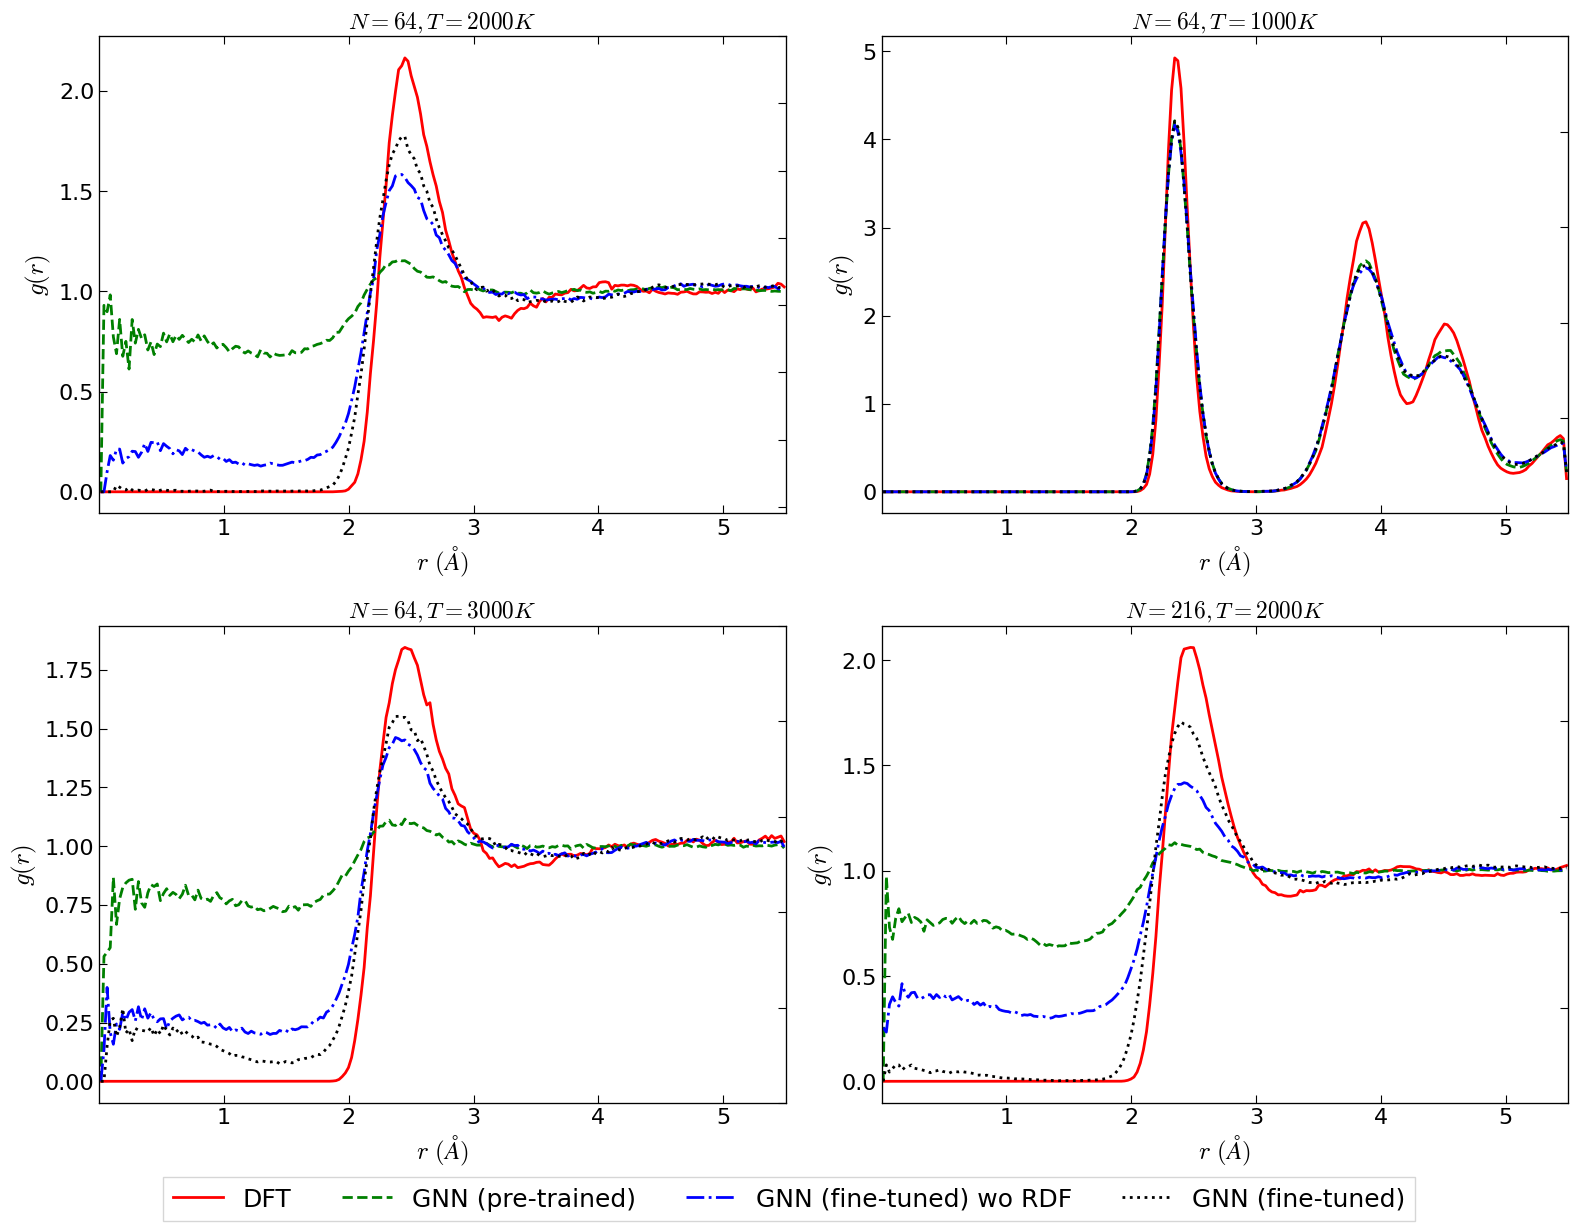

In [24]:
fig, ax1 = plt.subplots(2, 2,figsize=(16, 12))

ax2 = ax1[0,0].twinx()
ax3 = ax1[0,0].twiny()
ax1[0,0].set_ylabel(r"$g(r)$",fontsize=18)
ax1[0,0].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[0,0].title.set_text(r'$N=64, T=2000K$')
ax1[0,0].plot(r_mdt_DFT, gr_mdt_DFT, linewidth=2, label='DFT', color='red')
ax1[0,0].plot(r_mdt, gr_mdt, linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[0,0].plot(r_mdt_ft, gr_mdt_ft, linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[0,0].plot(r_mdt_rdf_ft, gr_mdt_rdf_ft, linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[0,0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0,0].tick_params(axis="x", direction='in', length=6, labelsize=16)

# ax1[0,0].set_ylim(-0.01,0.7)
ax1[0,0].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
ax2 = ax1[0,1].twinx()
ax3 = ax1[0,1].twiny()
ax1[0,1].set_ylabel(r"$g(r)$",fontsize=18)
ax1[0,1].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[0,1].title.set_text(r'$N=64, T=1000K$')
ax1[0,1].plot(r_mdt_DFT_1000K, gr_mdt_DFT_1000K, linewidth=2, label='DFT', color='red')
ax1[0,1].plot(r_mdt_1000K,  gr_mdt_1000K, linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[0,1].plot(r_mdt_ft_1000K,  gr_mdt_ft_1000K, linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[0,1].plot(r_mdt_rdf_ft_1000K,  gr_mdt_rdf_ft_1000K, linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[0,1].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0,1].tick_params(axis="x", direction='in', length=6, labelsize=16)

# ax1[0,1].set_ylim(-0.01,0.7)
ax1[0,1].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

# ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
ax2 = ax1[1,0].twinx()
ax3 = ax1[1,0].twiny()
ax1[1,0].set_ylabel(r"$g(r)$",fontsize=18)
ax1[1,0].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[1,0].title.set_text(r'$N=64, T=3000K$')
ax1[1,0].plot(r_mdt_DFT_3000K, gr_mdt_DFT_3000K, linewidth=2, label='DFT', color='red')
ax1[1,0].plot(r_mdt_3000K,  gr_mdt_3000K, linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[1,0].plot(r_mdt_ft_3000K,  gr_mdt_ft_3000K, linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[1,0].plot(r_mdt_rdf_ft_3000K,  gr_mdt_rdf_ft_3000K, linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[1,0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[1,0].tick_params(axis="x", direction='in', length=6, labelsize=16)

# ax1[1,0].set_ylim(-0.01,0.7)
ax1[1,0].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

# ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
ax2 = ax1[1,1].twinx()
ax3 = ax1[1,1].twiny()
ax1[1,1].set_ylabel(r"$g(r)$",fontsize=18)
ax1[1,1].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[1,1].title.set_text(r'$N=216, T=2000K$')
ax1[1,1].plot(r_mdt_DFT_216, gr_mdt_DFT_216, linewidth=2, label='DFT', color='red')
ax1[1,1].plot(r_mdt_216, gr_mdt_216, linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[1,1].plot(r_mdt_ft_216, gr_mdt_ft_216, linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[1,1].plot(r_mdt_rdf_ft_216, gr_mdt_rdf_ft_216, linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[1,1].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[1,1].tick_params(axis="x", direction='in', length=6, labelsize=16)
# ax1[1,1].set_ylim(-0.01,0.7)
ax1[1,1].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

# ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
handles_p, labels_p = ax1[1,1].get_legend_handles_labels()
fig.legend(handles_p,
           labels_p,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.02),
           fancybox=False,
           bbox_transform=fig.transFigure, ncol=4, fontsize=18)

plt.tight_layout()
plt.savefig("final_rdf.pdf", dpi=300,  bbox_inches='tight')
plt.show()

In [25]:
onp.save("radii", r_mdt_DFT_216)

onp.save("gr_converged", gr_mdt_DFT)
onp.save("gr", gr_mdt)
onp.save("gr_ft", gr_mdt_ft)
onp.save("gr_rdf_ft", gr_mdt_rdf_ft)

onp.save("gr_converged_1000K", gr_mdt_DFT_1000K)
onp.save("gr_1000K", gr_mdt_1000K)
onp.save("gr_1000K_ft", gr_mdt_ft_1000K)
onp.save("gr_1000K_rdf_ft", gr_mdt_rdf_ft_1000K)

onp.save("gr_converged_3000K", gr_mdt_DFT_3000K)
onp.save("gr_3000K", gr_mdt_3000K)
onp.save("gr_3000K_ft", gr_mdt_ft_3000K)
onp.save("gr_3000K_rdf_ft", gr_mdt_rdf_ft_3000K)

onp.save("gr_converged_216", gr_mdt_DFT_216)
onp.save("gr_216", gr_mdt_216)
onp.save("gr_216_ft", gr_mdt_ft_216)
onp.save("gr_216_rdf_ft", gr_mdt_rdf_ft_216)

In [26]:
!zip -r gr_comp.zip /content/gr* /content/radii.npy /content/radii_jaxmd.npy

  adding: content/gr_1000K_ft_jaxmd.npy (deflated 5%)
  adding: content/gr_1000K_ft.npy (deflated 36%)
  adding: content/gr_1000K_jaxmd.npy (deflated 5%)
  adding: content/gr_1000K.npy (deflated 36%)
  adding: content/gr_1000K_rdf_ft_jaxmd.npy (deflated 4%)
  adding: content/gr_1000K_rdf_ft.npy (deflated 35%)
  adding: content/gr_216_ft_jaxmd.npy (deflated 8%)
  adding: content/gr_216_ft.npy (deflated 6%)
  adding: content/gr_216_jaxmd.npy (deflated 10%)
  adding: content/gr_216.npy (deflated 8%)
  adding: content/gr_216_rdf_ft_jaxmd.npy (deflated 7%)
  adding: content/gr_216_rdf_ft.npy (deflated 7%)
  adding: content/gr_3000K_ft_jaxmd.npy (deflated 8%)
  adding: content/gr_3000K_ft.npy (deflated 7%)
  adding: content/gr_3000K_jaxmd.npy (deflated 10%)
  adding: content/gr_3000K.npy (deflated 8%)
  adding: content/gr_3000K_rdf_ft_jaxmd.npy (deflated 7%)
  adding: content/gr_3000K_rdf_ft.npy (deflated 7%)
  adding: content/gr_converged_1000K_jaxmd.npy (deflated 5%)
  adding: content/gr_c

In [28]:
'''fig, ax1 = plt.subplots(2, 2,figsize=(16, 12))

ax2 = ax1[0,0].twinx()
ax3 = ax1[0,0].twiny()
ax1[0,0].set_ylabel(r"$g(r)$",fontsize=18)
ax1[0,0].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[0,0].title.set_text(r'$N=64, T=2000K$')
ax1[0,0].plot(r, gr_converged, linewidth=2, label='DFT', color='red')
ax1[0,0].plot(r, jnp.mean(gr, axis=0), linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[0,0].plot(r, jnp.mean(gr_ft, axis=0), linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[0,0].plot(r, jnp.mean(gr_rdf_ft, axis=0), linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[0,0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0,0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0,0].set_ylim(-0.01,0.7)
ax1[0,0].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
ax2 = ax1[0,1].twinx()
ax3 = ax1[0,1].twiny()
ax1[0,1].set_ylabel(r"$g(r)$",fontsize=18)
ax1[0,1].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[0,1].title.set_text(r'$N=64, T=1000K$')
ax1[0,1].plot(r, gr_converged_1000K, linewidth=2, label='DFT', color='red')
ax1[0,1].plot(r,  jnp.mean(gr_1000K, axis=0), linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[0,1].plot(r,  jnp.mean(gr_1000K_ft, axis=0), linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[0,1].plot(r,  jnp.mean(gr_1000K_rdf_ft, axis=0), linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[0,1].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0,1].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0,1].set_ylim(-0.01,0.7)
ax1[0,1].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
ax2 = ax1[1,0].twinx()
ax3 = ax1[1,0].twiny()
ax1[1,0].set_ylabel(r"$g(r)$",fontsize=18)
ax1[1,0].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[1,0].title.set_text(r'$N=64, T=3000K$')
ax1[1,0].plot(r, gr_converged_3000K, linewidth=2, label='DFT', color='red')
ax1[1,0].plot(r,  jnp.mean(gr_3000K, axis=0), linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[1,0].plot(r,  jnp.mean(gr_3000K_ft, axis=0), linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[1,0].plot(r,  jnp.mean(gr_3000K_rdf_ft, axis=0), linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[1,0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[1,0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[1,0].set_ylim(-0.01,0.7)
ax1[1,0].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
ax2 = ax1[1,1].twinx()
ax3 = ax1[1,1].twiny()
ax1[1,1].set_ylabel(r"$g(r)$",fontsize=18)
ax1[1,1].set_xlabel(r"$r\ (\AA)$", fontsize=18)
ax1[1,1].title.set_text(r'$N=216, T=2000K$')
ax1[1,1].plot(r, gr_converged_216, linewidth=2, label='DFT', color='red')
ax1[1,1].plot(r,  jnp.mean(gr_216, axis=0), linewidth=2, label='GNN (pre-trained)', color='green', ls='--')
ax1[1,1].plot(r,  jnp.mean(gr_216_ft, axis=0), linewidth=2, label='GNN (fine-tuned) wo RDF', color='blue', ls='-.')
ax1[1,1].plot(r,  jnp.mean(gr_216_rdf_ft, axis=0), linewidth=2, label='GNN (fine-tuned)', color='black', ls=':')

ax1[1,1].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[1,1].tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1[1,1].set_ylim(-0.01,0.7)
ax1[1,1].set_xlim([r[0], r[-1]])

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax2.set_ylim(-0.01,0.7)
ax3.set_xlim([r[0], r[-1]])
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

# --- #
handles_p, labels_p = ax1[1,1].get_legend_handles_labels()
fig.legend(handles_p,
           labels_p,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.02),
           fancybox=False,
           bbox_transform=fig.transFigure, ncol=4, fontsize=18)

plt.tight_layout()
plt.savefig("final_rdf2.pdf", dpi=300,  bbox_inches='tight')
plt.show()'''

'fig, ax1 = plt.subplots(2, 2,figsize=(16, 12))\n\nax2 = ax1[0,0].twinx()\nax3 = ax1[0,0].twiny()\nax1[0,0].set_ylabel(r"$g(r)$",fontsize=18)\nax1[0,0].set_xlabel(r"$r\\ (\\AA)$", fontsize=18)\nax1[0,0].title.set_text(r\'$N=64, T=2000K$\')\nax1[0,0].plot(r, gr_converged, linewidth=2, label=\'DFT\', color=\'red\')\nax1[0,0].plot(r, jnp.mean(gr, axis=0), linewidth=2, label=\'GNN (pre-trained)\', color=\'green\', ls=\'--\')\nax1[0,0].plot(r, jnp.mean(gr_ft, axis=0), linewidth=2, label=\'GNN (fine-tuned) wo RDF\', color=\'blue\', ls=\'-.\')\nax1[0,0].plot(r, jnp.mean(gr_rdf_ft, axis=0), linewidth=2, label=\'GNN (fine-tuned)\', color=\'black\', ls=\':\')\n\nax1[0,0].tick_params(axis="y", direction=\'in\', length=6, labelsize=16)\nax1[0,0].tick_params(axis="x", direction=\'in\', length=6, labelsize=16)\n\nax1[0,0].set_ylim(-0.01,0.7)\nax1[0,0].set_xlim([r[0], r[-1]])\n\nax2.tick_params(axis="y", direction=\'in\', length=6)\nax2.set_yticklabels([])\n\nax2.set_ylim(-0.01,0.7)\nax3.set_xlim([r[